Dataset exploration. Use pandas to load dataset and look at the first document

In [1]:
import pandas as pd

df = pd.read_json('https://storage.googleapis.com/swe-workshop-23/organizations.json')
df

,title,description,categories,picture_data
0,180 Degrees Consulting,The University of Texas at Dallas branch of 18...,[Academic Interests],iVBORw0KGgoAAAANSUhEUgAAA8AAAAPACAIAAAB1tIfMAA...
1,200percent,"The purpose of 200percent, as a K-pop performa...","[Cultural, Arts and Music, Special Interest]",/9j/4AAQSkZJRgABAQEBLAEsAAD/4Sx2RXhpZgAATU0AKg...
2,Aaja Nachle,To host one of the biggest BollyFusion Dance c...,"[Art and Music, Cultural]",iVBORw0KGgoAAAANSUhEUgAABJIAAAOaCAAAAADmcicgAA...
3,AAPG SEG Student Chapter,AAPG SEG Student Chapter brings together a gr...,"[Academic Interests, Educational/Departmental]",
4,AAPG Student Chapter,The AAPG chapter at UTD is a student-run profe...,[Academic Interests],
...,...,...,...,...
516,Writing Without Purpose,Writing Without Purpose is a creative writing ...,[Arts and Music],/9j/4QDKRXhpZgAATU0AKgAAAAgABgESAAMAAAABAAEAAA...
517,Writing Without Purpsoe,Writing Without Purpose is a creative writing ...,[Special Interest],
518,XR UTD,XR UTD aims to provide the UTD community with ...,[Special Interest],iVBORw0KGgoAAAANSUhEUgAAD6AAAAoLCAYAAADPnC2IAA...
519,Young Democratic Socialists of America,UTD YDSA is a youth chapter of the Democratic ...,[Political],


In [2]:
nebula = df[df['title'] == 'Nebula Labs']
nebula

,title,description,categories,picture_data
315,Nebula Labs,Nebula Labs is an interdisciplinary community ...,[Academic Interests],iVBORw0KGgoAAAANSUhEUgAAAgAAAAIACAYAAAD0eNT6AA...


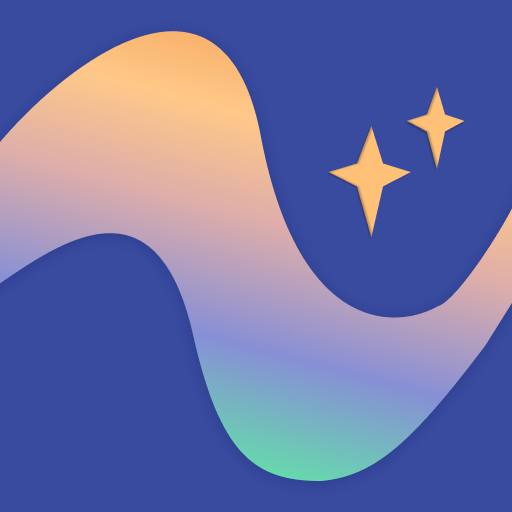

In [3]:
from io import BytesIO
from PIL import Image
from base64 import b64decode

encoded_image = nebula['picture_data'].iloc[0]
Image.open(BytesIO(b64decode(encoded_image)))

In [4]:
# format as documents

def format_as_doc(row):
    return f"Title: {row['title']}\nCategories: {', '.join(row['categories'])}\nDescription: {row['description']}\n"


df['content'] = df.apply(format_as_doc, axis=1)

nebula = df[df['title'] == 'Nebula Labs']

print(nebula['content'].iloc[0])

Title: Nebula Labs
Categories: Academic Interests
Description: Nebula Labs is an interdisciplinary community consisting of developers and designers that build tools for UT Dallas students like a degree planner and a tool to visualize professor data.

Our purpose is to:
* Create and maintain an interdisciplinary community of learners
* Improve the lives of others by providing a platform that allows students to build and maintain tools for the community
* Provide students opportunities to serve the UT Dallas community through experiential learning
* Host technical and design workshops, teach-ins, and other events for UT Dallas students

Our current projects in development are:
* Planner - An interactive degree planner
* Survival Guide - A wiki filled with information about life at UT Dallas
* Trends - A website that displays course grades, evals, and more
* Jupiter - A portal for everything related to student organizations
* API/Platform - The backend that supports all of our projects

I

In [5]:
from langchain.llms import HuggingFaceTextGenInference

hf = HuggingFaceTextGenInference(
    inference_server_url="https://hvxgjd4o670aom-8080.proxy.runpod.net/",
    max_new_tokens=512,
    do_sample=True,
    top_k=5,
)

response = hf("Hi! My name is Amrit! I'm a member of Nebula Labs, a student organization on campus dedicated to Open-Source projects built by students, for students. Today I will be talking to you about ")
print(response)

/home/amrit/projects/swe-workshop/venv/lib/python3.11/site-packages/pydantic/_internal/_fields.py:128: UserWarning: Field "model_id" has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(


"Open-Source Software for Students".
As a part of this talk, I would like to share with you a few examples of "Open-Source Software for Students" that we have been working with at Nebula Labs.
1. GIMP - A free, open-source image editing software.
2. Osmotic - A free, open-source, cross-platform, and multi-purpose data-collection tool.
3. Audacity - A free, open-source, cross-platform, and multi-purpose audio-editing software.
As a student, these are the types of software that we would like to use to do our projects. These are the types of software that are built by students, for students.
I'm not going to talk to you about the technical side of these software, but instead I want to talk to you about the benefits of using these software for students.
1. Cost-Effective: These software are free to use. You can use them to create your own projects and save money.
2. Flexibility: You can use these software on multiple operating systems. You don't need to worry about the hardware requirement

In [6]:
from langchain.schema import StrOutputParser

from langchain.prompts import PromptTemplate

prompt = PromptTemplate.from_template("""You are a student organization recommendation assistant. Given the user's interests, recommend a student organization on campus.

User interests: {interests}

Recommendation: """)

chain = prompt | hf | StrOutputParser()
response = chain.invoke({"interests": "computer science, soccer"})
print(response)

'CodeSoccer' student organization. This organization combines two of the user's passions - computer science and soccer - by providing opportunities for students to learn about and improve their coding skills while also participating in soccer games and events.


In [7]:
from langchain.embeddings import HuggingFaceEmbeddings

from langchain.vectorstores import Chroma

from langchain.document_loaders import DataFrameLoader

loader = DataFrameLoader(df[["title", "content"]], page_content_column='content')
documents = loader.load()
embeddings = HuggingFaceEmbeddings()
docsearch = Chroma.from_documents(documents, embeddings)

In [8]:
docsearch.similarity_search("computer science, soccer", k=5)

[Document(page_content='Title: Code.exe\nCategories: Academic Interests, Educational/Departmental\nDescription: Mission -\nTo make students well versed with coding languages and prepare them for various competitions and future job roles.\n\nThe purpose of this club shall be:\n1. To organize weekly sessions at the university for students to learn new technologies.\n2. To conduct workshops between students and industry professionals regarding new tools and\ntechnologies used in the industry.\n3. To provide a platform for collaboration among students, professors, and industry professionals to\nshare and enhance knowledge in the field of Information Technology.\n4. To encourage students to learn to code and explore various programming languages\n\nOrganization Description - \nThis organization believes technology can transform the world, and the road to transformative technology goes most of the time through programming or coding. Our organization hopes to make the transition of students w

In [9]:
from langchain.schema.runnable import RunnablePassthrough

retriever = docsearch.as_retriever(search_kwargs={"k": 5})

prompt = PromptTemplate.from_template(
    """You are a student organization recommendation assistant. Given the user's
    interests and some relevent search results from the campus student
    organization directory, recommend a student organization on campus as plain
    text, and give a short description of the organization.

User Interests: {interests}

Search Results:
=============
{context}
=============

Given the users interests and some relvent search results from the campus student organization directory, the recommended organization is """
)


def format_docs(docs):
    return "\n\n\n".join([d.page_content for d in docs])


chain = (
    {"context": retriever | format_docs, "interests": RunnablePassthrough()}
    | prompt
    | hf
    | StrOutputParser()
)

In [12]:
response = chain.invoke("women in stem")
print(response)

"Female Leaders of America in Science and Health" (FLASH). The organization provides a platform for students interested in the science fields, offering services, educational opportunities, and a supportive community. The organization is designed to empower women to succeed in their chosen STEM fields, and provides resources for personal development, networking, and mentorship.
